# Title Recommendation for Indonesian News Article Using Long Short-Term Memory with Attention Mechanism - [3rd Notebook]
### Final Project of Joshia Cahyadi - 10119086
---

*Notebook* ini adalah *notebook* ketiga dari 4 *notebook* lainnya. Terdapat 5 hal yang dilakukan pada notebook ini:
1. Mengolah data teks lebih lanjut (*tokenization* dan *padding*),
2. Mendefinisikan dan membangun model dengan mekanisme atensi,
3. Melatih model dengan mekanisme atensi,
4. Melakukan prediksi pada data uji (*test data*),
5. Menghitung dan menganalisis nilai BERTScore sebagai metrik evaluasi (*evaluation metric*).

# Melakukan Inisialisasi Libraries

In [ ]:
!pip install bert_score==0.3.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00


In [ ]:
# Libraries untuk manipulasi data
import pandas as pd
import numpy as np

# Libraries untuk interaksi dengan files
import io
import json

# Libraries untuk split data antara data training dan data validasi
from sklearn.model_selection import train_test_split

# Libraries untuk menampilkan grafik
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries untuk estetika print
import textwrap

# Libraries untuk menghitung BERTScore
# import bert_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
# Menginisialisasi data yang telah dibersihkan sebelumnya
df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Data Artikel 2 v3.csv')
df = df[['title','content_html']]

In [ ]:
# Menghilangkan baris yang identik
df = df.drop_duplicates()

In [ ]:
# Definisikan fungsi tag_title untuk melakukan tagging pada judul
def tag_title(title):
  tagged_article = '<start> ' + title + ' <end>'
  return tagged_article

# Definisikan fungsi lower_title untuk melakukan lowercase pada semua karakter/huruf pada judul
def lower_title(title):
  lowered_title = title.lower()
  return lowered_title

In [ ]:
# Mengaplikasikan fungsi tag_title ke semua data
df['title'] = df['title'].apply(lambda row: lower_title(tag_title(row)))

In [ ]:
# Memisahkan data untuk training dan testing model encoder-decoder sequence-to-sequence tanpa mekanisme atensi
df_training = df.sample(300000, random_state=0)
df_all = df.merge(df_training, on=['title','content_html'], how='left', indicator=True)
df_predict = df_all[df_all['_merge'] == 'left_only'][['title','content_html']]

In [ ]:
# Membuat dataframe untuk validasi
df_validating = df_predict.sample(30000, random_state=0)

In [ ]:
# Mengambil kolom 'content_html' dan 'title' untuk training
article_training = df_training['content_html']
title_training = df_training['title']

In [ ]:
# Mengambil kolom 'content_html' dan 'title' untuk validasi
article_validating = df_validating['content_html']
title_validating = df_validating['title']

In [ ]:
# Membuat dataframe untuk tes hasil prediksi
df_test = df_predict.merge(df_validating, how='left', on=['title','content_html'], indicator=True)
df_test = df_test[df_test['_merge'] == 'left_only'][['title','content_html']]

# Pengolahan Data

In [ ]:
# Inisialisasi beberapa libraries yang dibutuhkan
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Tokenisasi

In [ ]:
# Melakukan tokenisasi untuk data training dan validasi artikel berita

## Mendefinisikan tokenizer
article_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
article_tokenizer.fit_on_texts(list(article_training))

## Menerapkan tokenizer yang telah didefinisikan pada data artikel yang digunakan untuk training
article_training_tokenized = article_tokenizer.texts_to_sequences(article_training)
article_validating_tokenized = article_tokenizer.texts_to_sequences(article_validating)

## Menampilkan jumlah kosakata pada data training artikel
print('Jumlah kosakata yang ada pada data training artikel:', len(article_tokenizer.word_index) + 1, 'kosakata.')

Jumlah kosakata yang ada pada data training artikel: 665676 kosakata.


In [ ]:
# Melakukan tokenisasi untuk data training dan validasi judul berita

## Mendefinisikan tokenizer
title_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
title_tokenizer.fit_on_texts(list(title_training))

## Mendefinisikan fungsi untuk judul
def getting_copies_for_title(titles, tokenizer):
  '''
  Fungsi ini digunakan untuk memisahkan judul menjadi 2 bagian:
  1. Bagian yang digunakan untuk menghitung nilai loss dari hasil perbandingan kata hasil output decoder dengan kata sebenarnya.
  2. Bagian yang digunakan sebagai kata input selanjutnya bagi decoder.
  '''

  # Menerapkan tokenizer yang telah didefinisikan pada data judul yang digunakan untuk training
  tokenized_title = tokenizer.texts_to_sequences(titles)

  # Memisahkan judul menjadi bagian input dan target
  title_decoder_input = [title[:-1] for title in tokenized_title]
  title_decoder_target = [title[1:] for title in tokenized_title]

  return title_decoder_input, title_decoder_target

## Mendapatkan bagian input dan target untuk data training bagian judul
title_training_tokenized_input, title_training_tokenized_target = getting_copies_for_title(title_training, title_tokenizer)
title_validating_tokenized_input, title_validating_tokenized_target = getting_copies_for_title(title_validating, title_tokenizer)

In [ ]:
# Menampilkan jumlah kosakata pada data training judul
print('Jumlah kosakata yang ada pada data training judul:', len(title_tokenizer.word_index)+1)

Jumlah kosakata yang ada pada data training judul: 86847


## Padding

In [ ]:
# Mendefinisikan panjang maksimal dari setiap artikel dan judul
max_len_content = 500
max_len_title = 15

In [ ]:
# Melakukan padding pada data training
article_training_padded = pad_sequences(article_training_tokenized, maxlen=max_len_content, padding='post')
title_training_padded_input = pad_sequences(title_training_tokenized_input, maxlen=max_len_title, padding='post')
title_training_padded_target = pad_sequences(title_training_tokenized_target, maxlen=max_len_title, padding='post')

In [ ]:
# Melakukan padding pada data validasi
article_validating_padded = pad_sequences(article_validating_tokenized, maxlen=max_len_content, padding='post')
title_validating_padded_input = pad_sequences(title_validating_tokenized_input, maxlen=max_len_title, padding='post')
title_validating_padded_target = pad_sequences(title_validating_tokenized_target, maxlen=max_len_title, padding='post')

# Model

In [ ]:
# Definisikan beberapa hyperparameter yang akan digunakan
input_size_article = len(article_tokenizer.word_index)+1
input_size_title = len(title_tokenizer.word_index)+1
hidden_size = 200
embedding_dim = 150
batch_size = 128
epochs = 10
dropout_rate = 0.4

In [ ]:
# Inisialisasi library TensorFlow untuk melatih model
import tensorflow as tf

from tensorflow.keras.layers import Layer, Input, LSTM, Embedding, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.linalg import matmul
from tensorflow.keras.activations import softmax
from tensorflow import expand_dims, squeeze, concat, cast
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.math import not_equal
from tensorflow.data import Dataset

from keras import backend as K

K.clear_session()

## Encoder

In [ ]:
# Definisikan arsitektur encoder
class Encoder(Model):
  def __init__(self, input_dim, hidden_size, embedding_dim):
    super(Encoder, self).__init__()

    # Menginisialisasi Embedding, LSTM 1, LSTM 2, dan Concatenate layer dari Encoder
    self.encoder_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim, name='EncoderEmbedding')
    self.encoder_lstm1 = Bidirectional(LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate), name='BidirectionalLSTM1')
    self.encoder_lstm2 = Bidirectional(LSTM(units=hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate), name='BidirectionalLSTM2')
    self.concatenate_layer = Concatenate()

  def call(self, encoder_input):

    # Menerapkan Embedding pada input sequence
    encoder_embedding_output = self.encoder_embedding(encoder_input)

    # Menerapkan LSTM 1 dan LSTM 2 pada hasil embedding
    encoder_lstm1_output, encoder_lstm1_hidden_forward, encoder_lstm1_hidden_backward, encoder_lstm1_cell_forward, encoder_lstm1_cell_backward = self.encoder_lstm1(encoder_embedding_output)
    encoder_lstm2_output, encoder_lstm2_hidden_forward, encoder_lstm2_hidden_backward, encoder_lstm2_cell_forward, encoder_lstm2_cell_backward = self.encoder_lstm2(encoder_lstm1_output)

    # Melakukan konkatenasi untuk hidden dan cell state dari forward dan backward step
    encoder_final_hidden = self.concatenate_layer([encoder_lstm2_hidden_forward, encoder_lstm2_hidden_backward])
    encoder_final_cell = self.concatenate_layer([encoder_lstm2_cell_forward, encoder_lstm2_cell_backward])

    # Mengembalikan hasil Encoder
    return encoder_lstm2_output, encoder_final_hidden, encoder_final_cell

## Mekanisme Atensi

In [ ]:
# Definisikan arsitektur mekanisme atensi
class Attention(Model):
  def __init__(self):
    super(Attention, self).__init__()

  def call(self, inputs):

    encoder_hiddens, decoder_hidden = inputs

    # Menghitung nilai atau skor atensi (melakukan dot product antara hidden state dari decoder dengan semua hidden state dari encoder)
    attention_scores = matmul(decoder_hidden, encoder_hiddens, transpose_b=True)

    # Mengubah skor atensi menjadi distribusi peluang dengan softmax
    attention_prob_distributions = softmax(attention_scores, axis=-1)

    # Mendapatkan vektor konteks dengan cara menjumlahkan semua hidden state dari encoder yang masing-masingnya telah diproporsi sesuai dengan skor atensi.
    context_vector = matmul(attention_prob_distributions, encoder_hiddens)

    # Mengembalikan vektor konteks yang akan digabungkan dengan hidden state dari decoder
    return context_vector

## Decoder

In [ ]:
# Definisikan arsitektur decoder
class Decoder(Model):
  def __init__(self, input_dim, hidden_size, embedding_dim):
    super(Decoder, self).__init__()

    # Menginisialisasi Embedding, LSTM, Attention, Attentional, dan Dense layer untuk Decoder
    self.decoder_embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim, name='DecoderEmbedding')
    self.decoder_lstm1 = LSTM(units=hidden_size*2, return_sequences=True, return_state=True, dropout=dropout_rate, name='DecoderLSTM1')
    self.attention = Attention()
    self.attentional_hidden_state_layer = Dense(units=hidden_size, activation='tanh', name='AttentionalHiddenStateLayer')
    self.decoder_dense = Dense(units=input_size_title, name='DecoderDense')

  def call(self, decoder_inputs):

    decoder_input, encoder_hiddens, encoder_final_states = decoder_inputs

    # Menerapkan Embedding pada input sequence
    decoder_embedding_output = self.decoder_embedding(decoder_input)

    # Menerapkan LSTM pada hasil embedding
    decoder_lstm1_output, decoder_lstm1_hidden, decoder_lstm1_cell = self.decoder_lstm1(decoder_embedding_output, initial_state=encoder_final_states)

    # Mendapatkan vektor konteks dari hasil atensi
    context_vector = self.attention([encoder_hiddens, decoder_lstm1_output])

    # Menggabungkan hidden state dari decoder dengan vektor konteks dari hasil atensi
    concatenated_do_cv = concat([squeeze(decoder_lstm1_output, 1), squeeze(context_vector, 1)], -1) # do: decoder_lstm1_output, cv: context_vector

    # Menerapkan fungsi tanh pada hasil penggabungan di atas (sesuai paper Luong et al.)
    decoder_output_temporary = self.attentional_hidden_state_layer(concatenated_do_cv)

    # Mendapatkan hasil logits
    logits = self.decoder_dense(decoder_output_temporary)

    # Mengembalikan hasil logits, hidden state, dan cell state dari decoder
    return logits, decoder_lstm1_hidden, decoder_lstm1_cell

## Fungsi Loss

In [ ]:
# Definisikan fungsi loss
def scce_mask_loss_function(targets, predictions):

  # Inisialisasi fungsi Sparse Categorical Cross Entropy
  scce_loss = SparseCategoricalCrossentropy(from_logits=True)

  # Mendefinisikan mask agar padding tidak ikut dalam menentukan besarnya loss
  weight_mask = cast(not_equal(targets, 0), dtype=tf.float32)

  # Mengembalikan nilai loss
  return scce_loss(targets, predictions, sample_weight=weight_mask)

## Fungsi untuk Melatih Model

In [ ]:
class SequencetoSequenceTrainingFunction(Model):
  def __init__(self, encoder, decoder):
    super(SequencetoSequenceTrainingFunction, self).__init__()

    # Menginisialisasi encoder dan decoder yang telah dibuat sebelumnya
    self.encoder = encoder
    self.decoder = decoder

  @tf.function
  def train_step(self, data):
    encoder_input, decoder_input, decoder_target = data

    # Inisialisasi nilai loss
    loss_val = 0.

    # Inisialisasi panjang sequence yang harus didecode oleh decoder
    decoding_length = decoder_target.shape[1]

    with tf.GradientTape() as tape:

      # Memasukkan artikel berita ke dalam encoder
      # Mendapatkan hasil berupa:
      #  1. Hidden state dari setiap timestep yang akan digunakan untuk mekanisme atensi
      #  2. Final hidden state dan final cell state yang akan digunakan untuk inisialisasi hidden state dan cell state dari decoder
      encoder_outputs, decoder_hidden, decoder_cell = self.encoder(encoder_input)

      # Looping untuk proses decoding
      for i in range(decoding_length):

        # Inisialisasi input selanjutnya yang akan masuk ke decoder
        next_decoding_input = expand_dims(decoder_input[:, i], 1)

        # Memasukkan next_decoding_input ke dalam decoder
        # Mendapatkan hasil berupa:
        #  1. logits: sebuah vektor dengan ukuran (1 x input_size_title) yang berisi nilai hasil perhitungan decoder
        #  2. Hidden state dan cell state yang akan diterukan ke decoder timestep berikutnya
        logits, decoder_hidden, decoder_cell = self.decoder([next_decoding_input, encoder_outputs, (decoder_hidden, decoder_cell)])

        # Mengakumulasi nilai loss
        loss_val += self.loss(decoder_target[:, i], logits)

    # Mendapatkan semua variabel yang dapat ditrain dalam model
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables

    # Menghitung gradient untuk backpropagation
    gradients = tape.gradient(loss_val, trainable_vars)

    # Mengaplikasikan gradient ke semua variabel yang dapat ditrain
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Mengembalikan nilai loss untuk setiap epoch
    return {'Loss': loss_val/decoding_length}

  @tf.function
  def test_step(self, data_validation):
    encoder_input_test, decoder_input_test, decoder_target_test = data_validation

    loss_val_test = 0.

    decoding_length_test = decoder_target_test.shape[1]

    encoder_outputs_test, decoder_hidden_test, decoder_cell_test = self.encoder(encoder_input_test, training=False)

    for i in range(decoding_length_test):
      next_decoding_input_test = expand_dims(decoder_input_test[:, i], 1)
      logits_test, decoder_hidden_test, decoder_cell_test = self.decoder([next_decoding_input_test, encoder_outputs_test, (decoder_hidden_test, decoder_cell_test)], training=False)
      loss_val_test += self.loss(decoder_target_test[:, i], logits_test)

    return {'val_loss': loss_val_test/decoding_length_test}

# Melatih Model

In [ ]:
# Inisialisasi dataset menggunakan tensorflow datasets

## Inisialisasi dataset untuk training
training_dataset = Dataset.from_tensor_slices((article_training_padded,
                                               title_training_padded_input,
                                               title_training_padded_target)).batch(batch_size, drop_remainder=True)

## Inisialisasi dataset untuk validasi
validation_dataset = Dataset.from_tensor_slices((article_validating_padded,
                                                 title_validating_padded_input,
                                                 title_validating_padded_target)).batch(batch_size, drop_remainder=True)

In [ ]:
# Inisialisasi encoder, decoder, dan optimizer
encoder = Encoder(input_dim=input_size_article, hidden_size=hidden_size, embedding_dim=embedding_dim)
decoder = Decoder(input_dim=input_size_title, hidden_size=hidden_size, embedding_dim=embedding_dim)
optimizer = tf.keras.optimizers.Adam()

# Inisialisasi model keseluruhan
model = SequencetoSequenceTrainingFunction(encoder=encoder, decoder=decoder)

# Compile model
model.compile(optimizer=optimizer, loss=scce_mask_loss_function)

In [ ]:
# Inisialisasi encoder, decoder, dan optimizer
encoder = Encoder(input_dim=input_size_article, hidden_size=hidden_size, embedding_dim=embedding_dim)
decoder = Decoder(input_dim=input_size_title, hidden_size=hidden_size, embedding_dim=embedding_dim)
optimizer = tf.keras.optimizers.Adam()

# Inisialisasi model keseluruhan
model = SequencetoSequenceTrainingFunction(encoder=encoder, decoder=decoder)

In [ ]:
# Melatih model
history = model.fit(training_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
2343/2343 [==============================] - ETA: 0s - Loss: 5.5525

2343/2343 [==============================] - 1385s 575ms/step - Loss: 5.5524 - val_val_loss: 5.6619
Epoch 2/10
2343/2343 [==============================] - ETA: 0s - Loss: 5.5191

2343/2343 [==============================] - 1176s 502ms/step - Loss: 5.5190 - val_val_loss: 5.6825
Epoch 3/10
2343/2343 [==============================] - ETA: 0s - Loss: 5.0265

2343/2343 [==============================] - 1188s 507ms/step - Loss: 5.0262 - val_val_loss: 4.6911
Epoch 4/10
2343/2343 [==============================] - ETA: 0s - Loss: 4.2780

2343/2343 [==============================] - 1195s 510ms/step - Loss: 4.2778 - val_val_loss: 4.1462
Epoch 5/10
2343/2343 [==============================] - ETA: 0s - Loss: 3.8030

2343/2343 [==============================] - 1197s 511ms/step - Loss: 3.8028 - val_val_loss: 3.8334
Epoch 6/10
2343/2343 [==============================] - ETA: 0s - Loss: 3.4442

2343/2343 [==============================] - 1198s 511ms/step - Loss: 3.4440 - val_val_loss: 3.5850
Epoch 7/10
2343/2343 [==============================] - ETA: 0s - Loss: 3.1231

2343/2343 [==============================] - 1198s 511ms/step - Loss: 3.1230 - val_val_loss: 3.4460
Epoch 8/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.8345

2343/2343 [==============================] - 1198s 511ms/step - Loss: 2.8344 - val_val_loss: 3.4037
Epoch 9/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.5750

2343/2343 [==============================] - 1200s 512ms/step - Loss: 2.5749 - val_val_loss: 3.4279
Epoch 10/10
2343/2343 [==============================] - ETA: 0s - Loss: 2.3457

2343/2343 [==============================] - 1199s 512ms/step - Loss: 2.3456 - val_val_loss: 3.4693


In [ ]:
# List nilai history loss dan val loss
# Terlihat nilai loss yang tercatat di history berbeda dengan yang ditampilkan
history.history

{'Loss': [5.310115814208984,
  5.287094593048096,
  4.350148677825928,
  3.758051633834839,
  3.3747103214263916,
  3.07662034034729,
  2.7889227867126465,
  2.5422983169555664,
  2.302004098892212,
  2.0841500759124756],
 'val_val_loss': [5.661916732788086,
  5.682474613189697,
  4.691068649291992,
  4.146205425262451,
  3.8334357738494873,
  3.5850493907928467,
  3.445965528488159,
  3.4036927223205566,
  3.4279303550720215,
  3.469327926635742]}

In [ ]:
# List manual nilai loss
loss_manual = [5.5524, 5.5190, 5.0262, 4.2778, 3.8028, 3.4440, 3.1230, 2.8344, 2.5749, 2.3456]

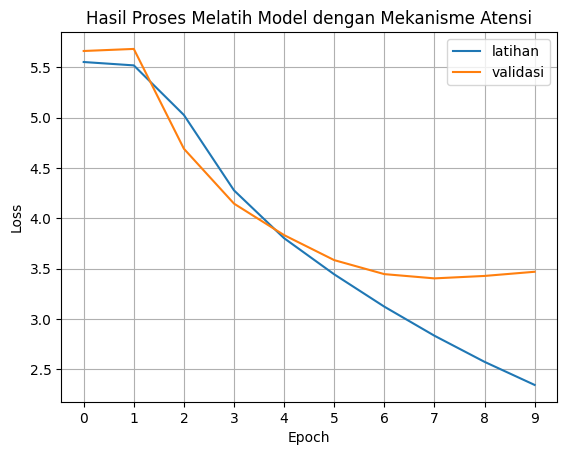

In [ ]:
# Plot hasil latihan model
import matplotlib.pyplot as plt
plt.plot(loss_manual, label='latihan')
plt.plot(history.history['val_val_loss'], label='validasi')
plt.title('Hasil Proses Melatih Model dengan Mekanisme Atensi')
plt.xticks([i for i in range(10)])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save encoder dan decoder
encoder.save_weights("/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/encoder_weights_v6_subclassing_new_data_v3_with_attention")
decoder.save_weights("/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/decoder_weights_v6_subclassing_new_data_v3_with_attention")

In [ ]:
# Save tokenizer
## Save article tokenizer
article_tokenizer_json = article_tokenizer.to_json()
with io.open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/article_tokenizer_v6_subclassing_new_data_v3_with_attention.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(article_tokenizer_json, ensure_ascii=False))

## Save title tokenizer
title_tokenizer_json = title_tokenizer.to_json()
with io.open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/title_tokenizer_v6_subclassing_new_data_v3_with_attention.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(title_tokenizer_json, ensure_ascii=False))

# Load Model

In [ ]:
# Load tokenizer

# Article tokenizer
with open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/article_tokenizer_v6_subclassing_new_data_v3_with_attention.json') as f:
  data = json.load(f)
  article_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

# Title tokenizer
with open('/content/drive/MyDrive/Tugas Akhir 2/Model/Tokenizer/title_tokenizer_v6_subclassing_new_data_v3_with_attention.json') as f:
  data = json.load(f)
  title_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [ ]:
encoder = Encoder(input_dim=input_size_article, hidden_size=hidden_size, embedding_dim=embedding_dim)
decoder = Decoder(input_dim=input_size_title, hidden_size=hidden_size, embedding_dim=embedding_dim)

In [ ]:
# Load model
encoder.load_weights('/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/encoder_weights_v6_subclassing_new_data_v3_with_attention')
decoder.load_weights('/content/drive/MyDrive/Tugas Akhir 2/Model/Model Final/decoder_weights_v6_subclassing_new_data_v3_with_attention')

# Melakukan prediksi

In [ ]:
# Load dataset yang digunakan untuk melakukan prediksi
df_test = pd.read_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Data Test Artikel 2 v3.csv')
df_test = df_test[['title','content_html']]

In [ ]:
# Definisikan fungsi untuk melakukan prediksi

## Fungsi ini akan menerima masukan berupa artikel berita
## Fungsi ini akan menghasilkan keluaran berupa judul berita

def generate_title_with_attention(input_text, article_tokenizer=article_tokenizer, title_tokenizer=title_tokenizer, encoder=encoder, decoder=decoder, max_title_length=15):
  input_sequence = article_tokenizer.texts_to_sequences([input_text])
  input_sequence = pad_sequences(input_sequence, maxlen=max_len_content, padding='post')

  # Inisialisasi kata pertama untuk decoder (sebagai tanda bagi decoder untuk mulai men-generate kata demi kata penyusun judul/title)
  current_word = '<start>'

  # Inisialisasi list untuk menampung kata-kata penyusun judul/title
  title_container = []

  # Mendapatkan state final (hidden state dan cell state) dari encoder yang akan dijadikan input untuk decoder
  encoder_output, hidden_state, cell_state = encoder.predict(input_sequence)

  while len(title_container) < max_title_length:

    # Inisialisasi vektor penampung untuk kata yang akan digunakan sebagai input untuk decoder
    input_word = np.zeros((1,1))

    # Mendapatkan index dari kata tersebut dan memasukkannnya ke dalam vektor penampung
    input_word[0, 0] = title_tokenizer.word_index[current_word]

    # Mendapatkan hasil dari decoder yang isinya
    #   1. Distribusi peluang dari semua kata yang mungkin digunakan sebagai judul
    #   2. Hidden State dan Cell State dari decoder
    decoder_output, hidden_state, cell_state = decoder.predict([input_word, encoder_output, (hidden_state,cell_state)], verbose=None)

    # Mendapatkan posisi (index) dari kata yang memiliki peluang tertinggi
    resulting_word_index = np.argmax(decoder_output[0])

    # Mendapatkan kata yang sebenarnya
    resulting_word = title_tokenizer.index_word[resulting_word_index]

    # Mengganti isi dari variabel current word dengan kata yang baru saja digenerate oleh Decoder, dan akan digunakan untuk input selanjutnya
    current_word = resulting_word

    # Jika kata yang digenerate oleh Decoder adalah "__end__", maka hal ini menandakan bahwa proses generate title sudah selesai
    if current_word == '<end>':
      break

    title_container.append(resulting_word)

  return " ".join(title_container)

In [ ]:
df_test

,title,content_html
0,"<start> pantau tahun baru, kapolda metro jaya ...",kapolda metro jaya irjen mochamad iriawan mema...
1,<start> awas! copet berkeliaran di ancol malam...,belasan orang mengantre di pos pengamanan sub ...
2,<start> dua gol kejutan manchester united di m...,manchester united mendulang poin sempurna atas...
3,<start> warga kecewa tidak ada panggung hibura...,perayaan malam pergantian tahun baru di pada t...
4,<start> ucapan selamat tahun baru 2017 dari pa...,panglima kodam jaya mayjen teddy lhaksmana dan...
...,...,...
94314,<start> polisi as tangkap pria bersenjata jela...,"kepolisian , amerika serikat menangkap seorang..."
94315,"<start> demi jualan di monas, pedagang mengaku...",sejumlah pedagang terciduk petugas pengamanan ...
94316,<start> nike bocorkan transfer coutinho ke bar...,penantian panjang philippe coutinho untuk bers...
94317,<start> sandiaga akan saksikan hitung mundur p...,wakil gubernur dki jakarta sandiaga uno besert...


In [ ]:
generate_title_with_attention(df_test['content_html'].iloc[0])

1/1 [==============================] - 19s 19s/step


'kapolda metro jaya sediakan sepeda motor trail di jakarta'

In [ ]:
generate_title_with_attention(df_test['content_html'].iloc[0])

1/1 [==============================] - 0s 282ms/step


'kapolda metro jaya sediakan sepeda motor trail di jakarta'

In [ ]:
generate_title_with_attention(df_test['content_html'].iloc[18])

1/1 [==============================] - 0s 292ms/step


'warga jakarta utara bersihkan sampah di malam tahun baru'

In [ ]:
sample_for_prediction = df_test.sample(1000, random_state=0)

In [ ]:
sample_for_prediction['title_wi_attention'] = sample_for_prediction['content_html'].apply(lambda row: generate_title_with_attention(row))

1/1 [==============================] - 0s 289ms/step


# BERTScore

In [ ]:
_, _, F1 = bert_score.score([sample_for_prediction['title_wi_attention'].iloc[0]], [sample_for_prediction['content_html'].iloc[0]], lang='id', verbose=None)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Menghitung nilai BERTScore
_, _, F1 = bert_score.score(sample_for_prediction['title_wi_attention'].to_list(), sample_for_prediction['content_html'].to_list(), lang='id', verbose=None)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Memasukkan BERTScore ke data
sample_for_prediction['BERTScore_wi_attention'] = F1.numpy()

In [ ]:
sample_for_prediction

,Unnamed: 0,title,content_html,title_wi_attention,BERTScore_wi_attention
26691,35126,"<start> pejabat pt pal tertangkap kpk, kemente...",kementerian badan usaha milik negara akan meni...,"bumn diduga terjaring ott kpk, bumn ditindak t...",0.572396
63051,83037,<start> dua buruh bangunan isap sabu alasannya...,"dian suchairi warga jl kamboja, desa bandar kh...",warga desa ini simpan sabu di jalan desa,0.602266
2463,3235,<start> bus wisata bogor 'uncal' beroperasi se...,jalan utama di sekitar istana bogor dan kebun ...,bus di ragunan ini bikin bus mangga kaki,0.587528
6354,8349,"<start> tanggapi kicauan sby, jokowi: kita har...",presiden joko widodo menanggapi dingin kicauan...,presiden jokowi jangan sebar hoax,0.562073
7794,10255,<start> ini bukti yang disita kpk saat tangkap...,undang nomor 41 tahun 2014 tentang peternakan ...,patrialis akbar jadi tersangka patrialis akbar,0.677301
...,...,...,...,...,...
54603,71931,"<start> duh, indeks kebahagiaan orang indonesi...",indeks kebahagiaan rata ratamanusia indonesia ...,startup indonesia jadi tren positif,0.576382
65932,86855,<start> elon musk bandingkan kecerdasan buatan...,"bos spacex, , menyebut lebih berbahaya ketimba...",bos rusia sebut rusia bisa jalin hubungan deng...,0.600335
63406,83518,<start> ribuan santri banyumas aksi tolak prog...,ribuan massa nahdliyin di kabupaten banyumas m...,ribuan relawan ajak kemenag cabut full day school,0.567359
49934,65796,"<start> h-5 lebaran, kalimalang mulai ramai di...","arus lalu lintas di sisi kalimalang, bekasi, k...",pemudik motor melintas di kalimalang masih padat,0.639689


In [ ]:
sample_for_prediction = sample_for_prediction.reset_index()

In [ ]:
sample_for_prediction = sample_for_prediction[['title','content_html','title_wi_attention','BERTScore_wi_attention']]

In [ ]:
sample_for_prediction

,title,content_html,title_wi_attention,BERTScore_wi_attention
0,"<start> pejabat pt pal tertangkap kpk, kemente...",kementerian badan usaha milik negara akan meni...,"bumn diduga terjaring ott kpk, bumn ditindak t...",0.572396
1,<start> dua buruh bangunan isap sabu alasannya...,"dian suchairi warga jl kamboja, desa bandar kh...",warga desa ini simpan sabu di jalan desa,0.602266
2,<start> bus wisata bogor 'uncal' beroperasi se...,jalan utama di sekitar istana bogor dan kebun ...,bus di ragunan ini bikin bus mangga kaki,0.587528
3,"<start> tanggapi kicauan sby, jokowi: kita har...",presiden joko widodo menanggapi dingin kicauan...,presiden jokowi jangan sebar hoax,0.562073
4,<start> ini bukti yang disita kpk saat tangkap...,undang nomor 41 tahun 2014 tentang peternakan ...,patrialis akbar jadi tersangka patrialis akbar,0.677301
...,...,...,...,...
995,"<start> duh, indeks kebahagiaan orang indonesi...",indeks kebahagiaan rata ratamanusia indonesia ...,startup indonesia jadi tren positif,0.576382
996,<start> elon musk bandingkan kecerdasan buatan...,"bos spacex, , menyebut lebih berbahaya ketimba...",bos rusia sebut rusia bisa jalin hubungan deng...,0.600335
997,<start> ribuan santri banyumas aksi tolak prog...,ribuan massa nahdliyin di kabupaten banyumas m...,ribuan relawan ajak kemenag cabut full day school,0.567359
998,"<start> h-5 lebaran, kalimalang mulai ramai di...","arus lalu lintas di sisi kalimalang, bekasi, k...",pemudik motor melintas di kalimalang masih padat,0.639689


In [ ]:
# Mengurutkan nilai BERTScore
sample_for_prediction['BERTScore_wi_attention'].sort_values(ascending=False)

526    0.709345
316    0.708385
988    0.703352
351    0.699543
43     0.694257
         ...   
670    0.528237
615    0.525803
577    0.519549
642    0.518637
267    0.513701
Name: BERTScore_wi_attention, Length: 1000, dtype: float32

In [ ]:
# Mendapatkan rataan nilai BERTScore
sample_for_prediction['BERTScore_wi_attention'].mean()

0.6054952

In [ ]:
sample_for_prediction['content_html'].iloc[526]

'bocah perempuan berusia 8 tahun ditemukan tewas di bawah ranjang rumah tetangganya di sungki, kecamatan kertapati, palembang, sabtu sore. mayat nf ditemukan di dalam karung, tidak mengenakan bawahan dan tangannya terikat. penemuan tersebut langsung dilaporkan ke polisi oleh pemilik rumah. polisi yang datang langsung melakukan olah tempat kejadian dan membawa jenazah ke kamar mayat rs bhayangkara palembang. nf diketahui menghilang sejak jumat . keluarganya mencari cari, namun tak kunjung menemukannya'

In [ ]:
sample_for_prediction['title_wi_attention'].iloc[526]

'jasad bocah 8 tahun ditemukan di dalam kamar di palembang'

In [ ]:
# Menyimpan hasil dalam file csv
sample_for_prediction.to_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Hasil BERTScore Model dengan Atensi Data 2 v3.csv', index=False)

# Analisis Hasil BERTScore

In [ ]:
# Load dataset yang sudah ada nilai BERTScore
df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir 2/Files/Hasil BERTScore Model dengan Atensi Data 2 v3.csv')
df

,title,content_html,title_wi_attention,BERTScore_wi_attention
0,"<start> pejabat pt pal tertangkap kpk, kemente...",kementerian badan usaha milik negara akan meni...,"bumn diduga terjaring ott kpk, bumn ditindak t...",0.572396
1,<start> dua buruh bangunan isap sabu alasannya...,"dian suchairi warga jl kamboja, desa bandar kh...",warga desa ini simpan sabu di jalan desa,0.602266
2,<start> bus wisata bogor 'uncal' beroperasi se...,jalan utama di sekitar istana bogor dan kebun ...,bus di ragunan ini bikin bus mangga kaki,0.587528
3,"<start> tanggapi kicauan sby, jokowi: kita har...",presiden joko widodo menanggapi dingin kicauan...,presiden jokowi jangan sebar hoax,0.562073
4,<start> ini bukti yang disita kpk saat tangkap...,undang nomor 41 tahun 2014 tentang peternakan ...,patrialis akbar jadi tersangka patrialis akbar,0.677301
...,...,...,...,...
995,"<start> duh, indeks kebahagiaan orang indonesi...",indeks kebahagiaan rata ratamanusia indonesia ...,startup indonesia jadi tren positif,0.576382
996,<start> elon musk bandingkan kecerdasan buatan...,"bos spacex, , menyebut lebih berbahaya ketimba...",bos rusia sebut rusia bisa jalin hubungan deng...,0.600335
997,<start> ribuan santri banyumas aksi tolak prog...,ribuan massa nahdliyin di kabupaten banyumas m...,ribuan relawan ajak kemenag cabut full day school,0.567359
998,"<start> h-5 lebaran, kalimalang mulai ramai di...","arus lalu lintas di sisi kalimalang, bekasi, k...",pemudik motor melintas di kalimalang masih padat,0.639689


In [ ]:
# Membuat kolom "article_length" untuk mendapatkan panjang artikel berta
df['article_length'] = df['content_html'].apply(lambda row: len(row.split(' ')))

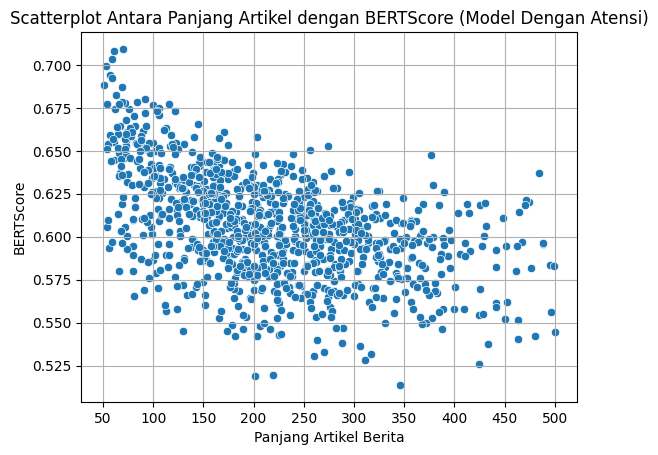

In [ ]:
# Menamplikan scatterplot antara "article_length" dengan BERTScore
sns.scatterplot(x=df['article_length'], y=df['BERTScore_wi_attention'])
plt.xlabel('Panjang Artikel Berita')
plt.ylabel('BERTScore')
plt.xticks([i*10 for i in range(5,51,5)])
plt.title('Scatterplot Antara Panjang Artikel dengan BERTScore (Model Dengan Atensi)')
plt.grid()
plt.show()

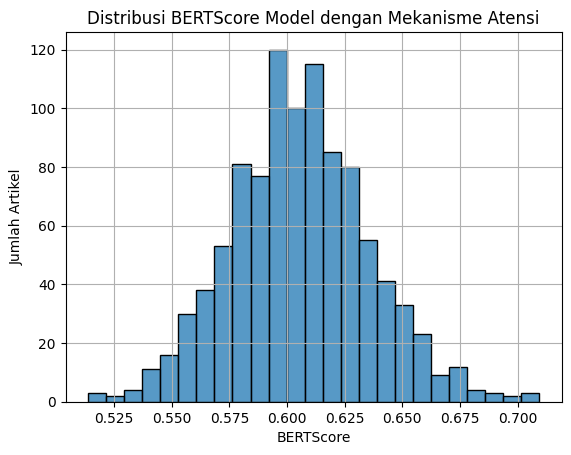

In [ ]:
# Menampilkan distribusi BERTScore
sns.histplot(df['BERTScore_wi_attention'])
plt.title('Distribusi BERTScore Model dengan Mekanisme Atensi')
plt.xlabel('BERTScore')
plt.ylabel('Jumlah Artikel')
plt.grid()
plt.show()

# Contoh untuk Buku TA

In [ ]:
# Mengurutkan nilai BERTScore
df['BERTScore_wi_attention'].sort_values(ascending=False)

526    0.709345
316    0.708385
988    0.703352
351    0.699543
43     0.694257
         ...   
670    0.528237
615    0.525803
577    0.519549
642    0.518637
267    0.513701
Name: BERTScore_wi_attention, Length: 1000, dtype: float64

In [ ]:
# Menghilangkan <start> dan <end> dari judul

## Definisikan fungsi untuk menghilangkan <start> dan <end>
def remove_start_end(title):
  return " ".join([word for word in title.split(' ') if word not in ['<start>','<end>']])

## Mengaplikasikan fungsi di atas ke seluruh judul
df['title'] = df['title'].apply(lambda row: remove_start_end(row))

## Contoh Pertama

In [ ]:
# Menampilkan isi artikel berita
content = df['content_html'].iloc[526]
content = textwrap.fill(content, width=100)

print('Isi Artikel Berita:')
print(content)

Isi Artikel Berita:
bocah perempuan berusia 8 tahun ditemukan tewas di bawah ranjang rumah tetangganya di sungki,
kecamatan kertapati, palembang, sabtu sore. mayat nf ditemukan di dalam karung, tidak mengenakan
bawahan dan tangannya terikat. penemuan tersebut langsung dilaporkan ke polisi oleh pemilik rumah.
polisi yang datang langsung melakukan olah tempat kejadian dan membawa jenazah ke kamar mayat rs
bhayangkara palembang. nf diketahui menghilang sejak jumat . keluarganya mencari cari, namun tak
kunjung menemukannya


In [ ]:
# Menampilkan judul asli
print('Judul Asli:')
print(df['title'].iloc[526])

Judul Asli:
jasad bocah 8 tahun di dalam karung ditemukan di bawah ranjang tetangga


In [ ]:
# Menampilkan judul keluaran model dengan mekanisme atensi
print('Judul Keluaran Model dengan Mekanisme Atensi:')
generate_title_with_attention(df['content_html'].iloc[526])

Judul Keluaran Model dengan Mekanisme Atensi:
1/1 [==============================] - 0s 361ms/step


'jasad bocah 8 tahun ditemukan di dalam kamar di palembang'

## Contoh Kedua

In [ ]:
# Menampilkan isi artikel berita
content = df['content_html'].iloc[316]
content = textwrap.fill(content, width=100)

print('Isi Artikel Berita:')
print(content)

Isi Artikel Berita:
mantan ketua umum partai demokrat anas urbaningrum diperiksa komisi pemberantasan korupsi selama
lima jam. pemeriksaan itu terkait dengan kasus korupsi pengadaan proyek kartu tanda penduduk
berbasis elektronik . anas yang memakai topi dan masker, dicegat awak media sebelum masuk mobil
tahanan. terpidana korupsi hambalang itu membantah tudingan mantan bendahara umum partai demokrat
muhammad nazaruddin yang menyebut ia terlibat dalam korupsi ini


In [ ]:
# Menampilkan judul asli
print('Judul Asli:')
print(df['title'].iloc[316])

Judul Asli:
anas urbaningrum bantah jadi dalang korupsi e-ktp  


In [ ]:
# Menampilkan judul keluaran model dengan mekanisme atensi
print('Judul Keluaran Model dengan Mekanisme Atensi:')
generate_title_with_attention(df['content_html'].iloc[316])

Judul Keluaran Model dengan Mekanisme Atensi:
1/1 [==============================] - 0s 277ms/step


'anas urbaningrum diperiksa dalam kasus korupsi e ktp'